In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt 

In [3]:
data = pd.read_csv('final_dataset.csv')  


In [5]:
X = data.drop('Exercise Recommendation Plan', axis=1)  
y = data['Exercise Recommendation Plan']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


In [29]:
numerical_features = ['Weight', 'Height', 'BMI', 'Age']
categorical_features = ['Gender', 'BMIcase']

In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

In [33]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [35]:
y_train_encoded = pd.get_dummies(y_train).values
y_test_encoded = pd.get_dummies(y_test).values

In [37]:
model = keras.Sequential([
    layers.Input(shape=(X_train_processed.shape[1],)),  
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.05)),  
    layers.Dropout(0.4), 
    layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.05)),  
    layers.Dropout(0.4), 
    layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.05)),  
    layers.Dense(y_train_encoded.shape[1], activation='softmax')  
])

In [39]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [43]:
history = model.fit(X_train_processed, y_train_encoded, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[early_stopping])


Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2142 - loss: 5.6369 - val_accuracy: 0.8183 - val_loss: 3.7833
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5298 - loss: 3.4446 - val_accuracy: 0.8850 - val_loss: 2.4281
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6674 - loss: 2.3173 - val_accuracy: 0.8900 - val_loss: 1.7001
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7414 - loss: 1.7427 - val_accuracy: 0.8917 - val_loss: 1.3436
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7777 - loss: 1.4576 - val_accuracy: 0.8917 - val_loss: 1.1661
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7794 - loss: 1.3643 - val_accuracy: 0.8917 - val_loss: 1.0652
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8250 - loss: 1.2088 - val_accuracy: 0.8917 - val_loss: 0.9970
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8257 - loss: 1.1565 - val_accuracy: 0.8917 - v

In [44]:
loss, accuracy = model.evaluate(X_test_processed, y_test_encoded)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9849 - loss: 0.4333
Test Loss: 0.4212, Test Accuracy: 0.9900


In [85]:
model.save('my_model.keras')

In [87]:
plt.figure(figsize=(14, 5))


<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

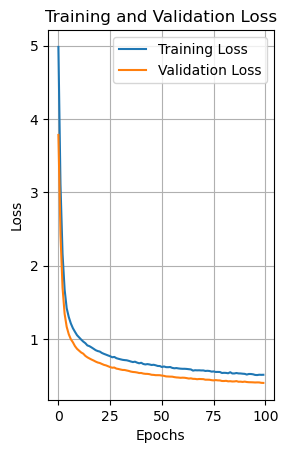

In [89]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

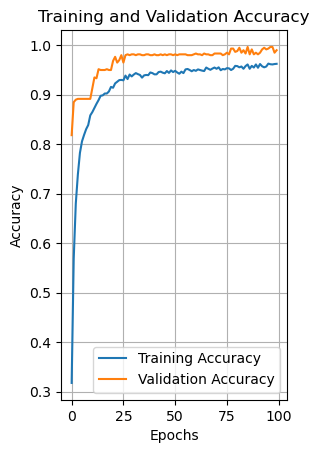

In [91]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()


In [93]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Text(400.83986928104576, 0.5, 'True')

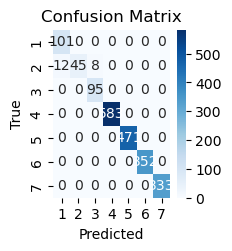

In [61]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score

y_pred = model.predict(X_test_processed)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
y_test_classes = tf.argmax(y_test_encoded, axis=1).numpy()

cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.subplot(2, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pd.get_dummies(y).columns, yticklabels=pd.get_dummies(y).columns)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
